In [1]:
%matplotlib inline

import sys, os  # include modules to the path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
sys.path.append(os.path.join(parent_dir, 'session'))
sys.path.append(os.path.join(parent_dir, 'postprocessing'))

import os
import numpy as np
import h5py, json
import matplotlib.pyplot as plt

from scipy import stats as scipystats
from scipy import signal
from datetime import datetime
from session.utils import session_to_numbers, cleaned_epochs, get_sessions_list
from session.lists import processed_008228, processed_008229
from session.adapters import EPOCH_NAMES, H5NAMES
from postprocessing.spatial import cart2pol, pol2cart

np.set_printoptions(suppress=True)

In [2]:
source  = '/home/sobolev/nevermind/Andrey/data'
animals = ['006618']
animal  = animals[0]

In [3]:
#sessions = processed_008228 + processed_008229
sessions = get_sessions_list(os.path.join(source, animal), animal)

## Occupancy maps for Trial / ITIs

In [4]:
session = sessions[1]
s_path = os.path.join(source, animal, session)
h5name = os.path.join(s_path, session + '.h5')

with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed
    trial_idxs = np.array(f['processed']['trial_idxs'])  # idx start, idx end, X, Y, R, trial result (idx to tl)
    islands = np.array(f['raw']['islands'])  # tgt_x, tgt_y, tgt_r, d1_x, d1_y, d1_r etc.
    cfg = json.loads(f['processed'].attrs['parameters'])
    arena_r = cfg['position']['floor_r_in_meters']

In [76]:
trial_nos = np.unique(tl[:, 5])
trial_nos = trial_nos[trial_nos > 0].astype(np.int16)
phi_fix = 180 # add 180 to put distractor in the fixed island place
titles = [
    'Aligned to Target (Trials)',
    'Aligned to Distractor (Trials)',
    'Aligned to Target (ITIs)',
    'Aligned to Distractor (ITIs)',
]

# --------- trials only
tl_to_plot = tl[np.where(tl[:, 5] > 0)[0]][:, 1:3]
isl_coords = np.vstack([islands[:, 3:5]] + [islands[0][0:2]])
isl_colors = ['red' for i in range(len(trial_nos))] + ['green']

# --------- ITIs only
tl_to_plot = tl[np.where(tl[:, 5] == 0)[0]][:, 1:3]
isl_coords = None
isl_colors = None

# --------- trials and ITIs, aligned to distractor
trial_trajs, iti_trajs, tgt_coor, dist_coor = [], [], [], []

for trial_no in trial_nos:
    x_tgt,  y_tgt  = islands[trial_no - 1][0], islands[trial_no - 1][1]  # target
    x_dist, y_dist = islands[trial_no - 1][3], islands[trial_no - 1][4]  # distractor
    rho, phi = cart2pol(x_dist, y_dist)
    rot_angle = phi + np.deg2rad(phi_fix)
    
    curr_trial_tl = tl[tl[:, 5] == float(trial_no)]
    next_trial_tl = tl[tl[:, 5] == float(trial_no + 1)]
    
    # select ITI trajectory
    if len(next_trial_tl) > 0:
        t_curr_trial_end = curr_trial_tl[-1][0]
        t_next_trial_beg = next_trial_tl[0][0]
        curr_iti_tl = tl[(tl[:, 0] > t_curr_trial_end) & (tl[:, 0] < t_next_trial_beg)]
        iti_trajs.append(rotate(curr_iti_tl[:, 1:3], rot_angle))
    
    trial_trajs.append(rotate(curr_trial_tl[:, 1:3], rot_angle))
    tgt_coor.append(rotate(np.array([[x_tgt,  y_tgt]]), rot_angle))
    dist_coor.append(rotate(np.array([[x_dist,  y_dist]]), rot_angle))
    
tl_to_plot = np.vstack(trial_trajs)
isl_coords = np.vstack(tgt_coor + [dist_coor[0]])
isl_colors = ['green' for i in range(len(trial_nos))] + ['red']

# --------- ITIs only, aligned to distractor
tl_to_plot = np.vstack(iti_trajs)
isl_coords = None
isl_colors = None

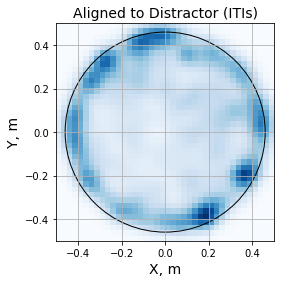

In [78]:
# tl_to_plot, isl_coords, isl_colors

sigma = 0.1
lin_profile = np.linspace(-15, 15, 20)
bump = np.exp(-sigma * lin_profile**2)
bump /= np.trapz(bump)  # normalize to 1
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
occupancy_map, _, _ = np.histogram2d(tl_to_plot[:, 0], tl_to_plot[:, 1], bins=[40, 40], range=np.array([[-0.5, 0.5], [-0.5, 0.5]]))
occupancy_map = signal.convolve2d(occupancy_map, kernel, mode='same')

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(occupancy_map.T, origin='lower', extent=(-0.5, 0.5, -0.5, 0.5), cmap='Blues')
ax.add_patch(plt.Circle((0, 0), arena_r, color='black', fill=False)) # arena boundaries

if isl_coords is not None:
    for i, isl in enumerate(isl_coords):
        alpha = 0.2 if i+1 < len(isl_coords) else 1
        ax.add_patch(plt.Circle((isl[0], isl[1]), 0.14, color=isl_colors[i], alpha=alpha, fill=False))

ax.set_xlabel('X, m', fontsize=14)
ax.set_ylabel('Y, m', fontsize=14)
ax.set_title(titles[3], fontsize=14)
ax.grid()

## Cmaps for Original, Conflict and Control

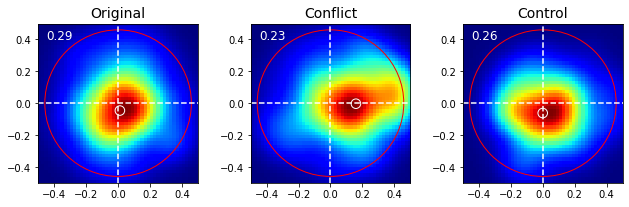

In [44]:
row_no, col_no = len(sessions), 3
extent = (-0.5, 0.5, -0.5, 0.5)
limits = (extent[0], extent[1], extent[2], extent[3])

fig = plt.figure(figsize=(3*col_no, 3*row_no))

for j, session in enumerate(sessions):
    h5path = os.path.join(source, session.split('_')[0], session, "%s.h5" % session)
    
    with h5py.File(h5path, 'r') as f:
        unit_name = [name for name in f['units']][0]
    
    with h5py.File(h5path, 'r') as f:
        o_maps    = np.array(f['units'][unit_name][H5NAMES.o_maps['name']])
        o_info    = np.array(f['units'][unit_name][H5NAMES.occ_info['name']])
        o_COM     = np.array(f['units'][unit_name][H5NAMES.o_COM['name']])
        cfg = json.loads(f['processed'].attrs['parameters'])
        arena_r = float(cfg['position']['floor_r_in_meters'])
    
    for i, o_map in enumerate(o_maps[:3]):
        x, y = pol2cart(o_COM[i][0], o_COM[i][1])

        ax = fig.add_subplot(row_no, col_no, j*col_no + i+1)
        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
        ax.imshow(o_map.T, cmap='jet', origin='lower', extent=extent)
        ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
        ax.add_patch(plt.Circle((x, y), 0.03, color='white', fill=False))
        ax.plot([0, 0], [-0.5, 0.5], color='white', ls='--')
        ax.plot([-0.5, 0.5], [0, 0], color='white', ls='--')
        ax.set_title(EPOCH_NAMES[i], fontsize=14, weight='bold' if i == len(o_maps) - 1 else 'normal')
        ax.text(-0.45, 0.4, round(o_info[i], 2), color='white', fontsize=12)
        
fig.tight_layout()